# Day 2: Random Forest for Trading

## 🎯 Learning Objectives
- Understand bagging and ensemble methods
- Master Random Forest algorithm
- Apply to trading signal generation
- Analyze out-of-bag error and feature importance

---

## 📚 Theory: Random Forest

### Bagging (Bootstrap Aggregating)
1. Create B bootstrap samples from training data
2. Train B trees, each on a bootstrap sample
3. Average predictions (regression) or vote (classification)

### Random Forest Enhancement
- At each split, consider only $m$ random features
- Default: $m = \sqrt{p}$ for classification, $m = p/3$ for regression
- Decorrelates trees → reduces variance

### Why It Works
$$Var(\bar{X}) = \rho\sigma^2 + \frac{1-\rho}{B}\sigma^2$$

Where $\rho$ is correlation between trees. Lower correlation = lower variance.

### Out-of-Bag (OOB) Error
- Each tree trained on ~63% of data
- Use remaining 37% for validation
- Free cross-validation estimate!

### Pros & Cons

| Pros | Cons |
|------|------|
| Low variance | Less interpretable |
| Handles high dimensions | Slow for large datasets |
| OOB error estimate | Can still overfit with deep trees |
| Robust to outliers | Memory intensive |

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix,
                             roc_auc_score)
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download data
ticker = 'AAPL'
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close']
volume = data['Volume']
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(prices)} days")

📥 Downloading data...
✅ Data: 1254 days


In [2]:
# Create comprehensive features
df = pd.DataFrame(index=prices.index)
df['price'] = prices
df['return'] = returns

# Momentum
for lag in [1, 5, 10, 20, 60]:
    df[f'momentum_{lag}'] = prices.pct_change(lag)

# Volatility
for window in [5, 10, 20]:
    df[f'volatility_{window}'] = returns.rolling(window).std()

# Volume
df['volume_ratio'] = volume / volume.rolling(20).mean()

# MA ratios
df['ma_5_20'] = prices.rolling(5).mean() / prices.rolling(20).mean() - 1
df['ma_20_50'] = prices.rolling(20).mean() / prices.rolling(50).mean() - 1

# RSI
delta = prices.diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
df['rsi'] = 100 - (100 / (1 + gain / loss))

# Bollinger position
ma_20 = prices.rolling(20).mean()
std_20 = prices.rolling(20).std()
df['bb_position'] = (prices - ma_20) / (2 * std_20)

# Target
df['next_return'] = returns.shift(-1)
df['target'] = (df['next_return'] > 0).astype(int)

df = df.dropna()
print(f"📊 Features: {len(df.columns)-3}, Samples: {len(df)}")

📊 Features: 14, Samples: 1193


In [3]:
# Prepare data
feature_cols = [c for c in df.columns if c not in ['price', 'return', 'next_return', 'target']]
X = df[feature_cols]
y = df['target']

# Split
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
returns_test = df['next_return'].iloc[split_idx:]

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 954, Test: 239


In [4]:
# Compare Single Tree vs Random Forest
single_tree = DecisionTreeClassifier(max_depth=5, random_state=42)
rf_100 = RandomForestClassifier(n_estimators=100, max_depth=5, oob_score=True, random_state=42)
rf_500 = RandomForestClassifier(n_estimators=500, max_depth=5, oob_score=True, random_state=42)

single_tree.fit(X_train, y_train)
rf_100.fit(X_train, y_train)
rf_500.fit(X_train, y_train)

print("\n" + "="*70)
print("SINGLE TREE vs RANDOM FOREST")
print("="*70)

print(f"\n{'Model':<25} {'Train Acc':>12} {'Test Acc':>12} {'OOB Score':>12}")
print("-" * 65)

models = [
    ('Single Tree', single_tree, None),
    ('Random Forest (100)', rf_100, rf_100.oob_score_),
    ('Random Forest (500)', rf_500, rf_500.oob_score_)
]

for name, model, oob in models:
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    oob_str = f'{oob:.4f}' if oob else 'N/A'
    print(f"{name:<25} {train_acc:>12.2%} {test_acc:>12.2%} {oob_str:>12}")


SINGLE TREE vs RANDOM FOREST

Model                        Train Acc     Test Acc    OOB Score
-----------------------------------------------------------------
Single Tree                     61.74%       51.88%          N/A
Random Forest (100)             77.78%       53.56%       0.5461
Random Forest (500)             77.57%       54.39%       0.5472


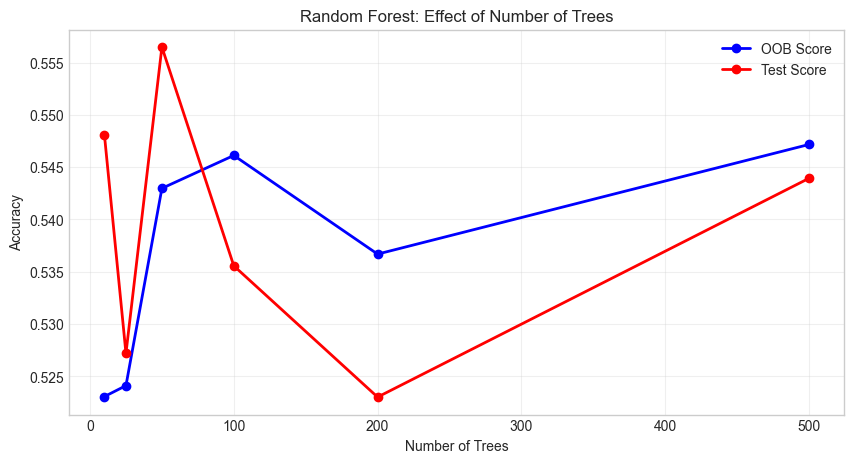

In [5]:
# Effect of number of trees
n_trees_range = [10, 25, 50, 100, 200, 500]
oob_scores = []
test_scores = []

for n in n_trees_range:
    rf = RandomForestClassifier(n_estimators=n, max_depth=5, oob_score=True, random_state=42)
    rf.fit(X_train, y_train)
    oob_scores.append(rf.oob_score_)
    test_scores.append(accuracy_score(y_test, rf.predict(X_test)))

plt.figure(figsize=(10, 5))
plt.plot(n_trees_range, oob_scores, 'b-o', label='OOB Score', linewidth=2)
plt.plot(n_trees_range, test_scores, 'r-o', label='Test Score', linewidth=2)
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Random Forest: Effect of Number of Trees')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [6]:
# Effect of max_features (feature subsampling)
max_features_range = [1, 3, 5, 7, 'sqrt', 'log2', None]

print("\n" + "="*70)
print("EFFECT OF max_features")
print("="*70)

mf_results = []
for mf in max_features_range:
    rf = RandomForestClassifier(n_estimators=100, max_depth=5, max_features=mf, 
                               oob_score=True, random_state=42)
    rf.fit(X_train, y_train)
    
    mf_results.append({
        'max_features': str(mf) if mf else 'All',
        'OOB Score': rf.oob_score_,
        'Test Acc': accuracy_score(y_test, rf.predict(X_test))
    })

mf_df = pd.DataFrame(mf_results)
print(mf_df.to_string(index=False))


EFFECT OF max_features
max_features  OOB Score  Test Acc
           1   0.550314  0.577406
           3   0.546122  0.535565
           5   0.529350  0.535565
           7   0.529350  0.523013
        sqrt   0.546122  0.535565
        log2   0.546122  0.535565
         All   0.525157  0.560669


In [7]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'max_features': ['sqrt', 5],
    'min_samples_leaf': [5, 10]
}

tscv = TimeSeriesSplit(n_splits=3)
rf_cv = RandomForestClassifier(random_state=42)

print("\n⏳ Running GridSearchCV...")
grid_search = GridSearchCV(rf_cv, param_grid, cv=tscv, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\n" + "="*60)
print("GRID SEARCH RESULTS")
print("="*60)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.4f}")

rf_best = grid_search.best_estimator_


⏳ Running GridSearchCV...

GRID SEARCH RESULTS
Best Parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 200}
Best CV Score: 0.5965


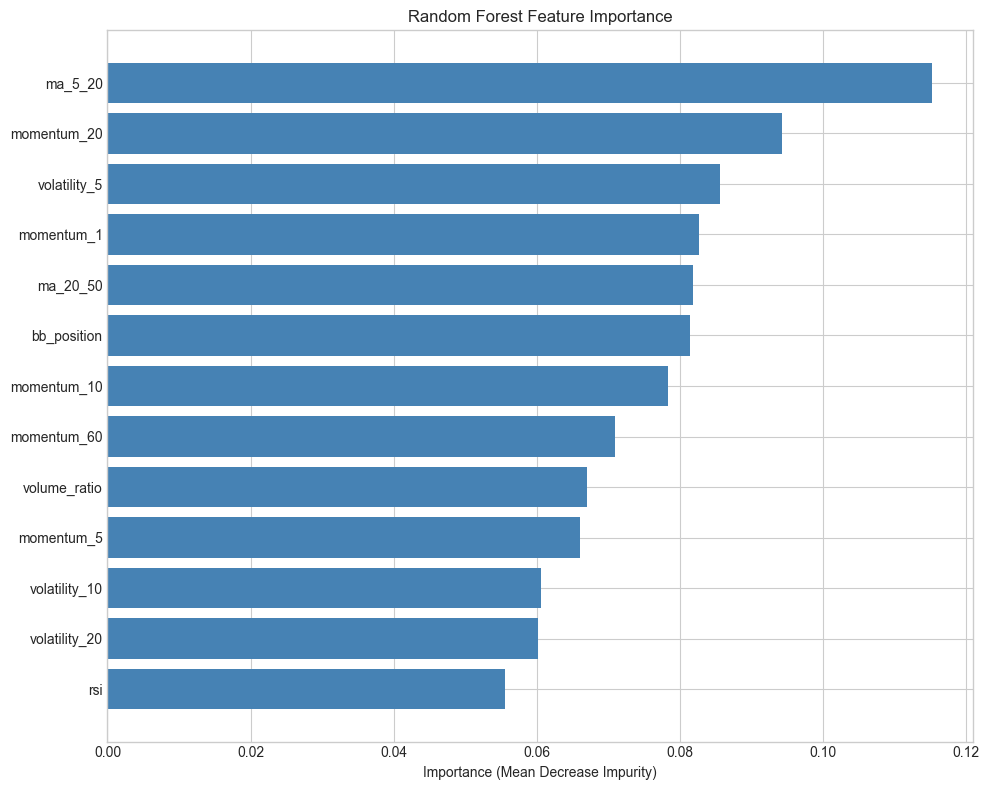


Top 5 Features:
     Feature  Importance
     ma_5_20    0.115256
 momentum_20    0.094319
volatility_5    0.085597
  momentum_1    0.082659
    ma_20_50    0.081870


In [8]:
# Feature Importance Analysis
importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_best.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(importance['Feature'], importance['Importance'], color='steelblue')
plt.xlabel('Importance (Mean Decrease Impurity)')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 5 Features:")
print(importance.head().to_string(index=False))


⏳ Computing permutation importance...


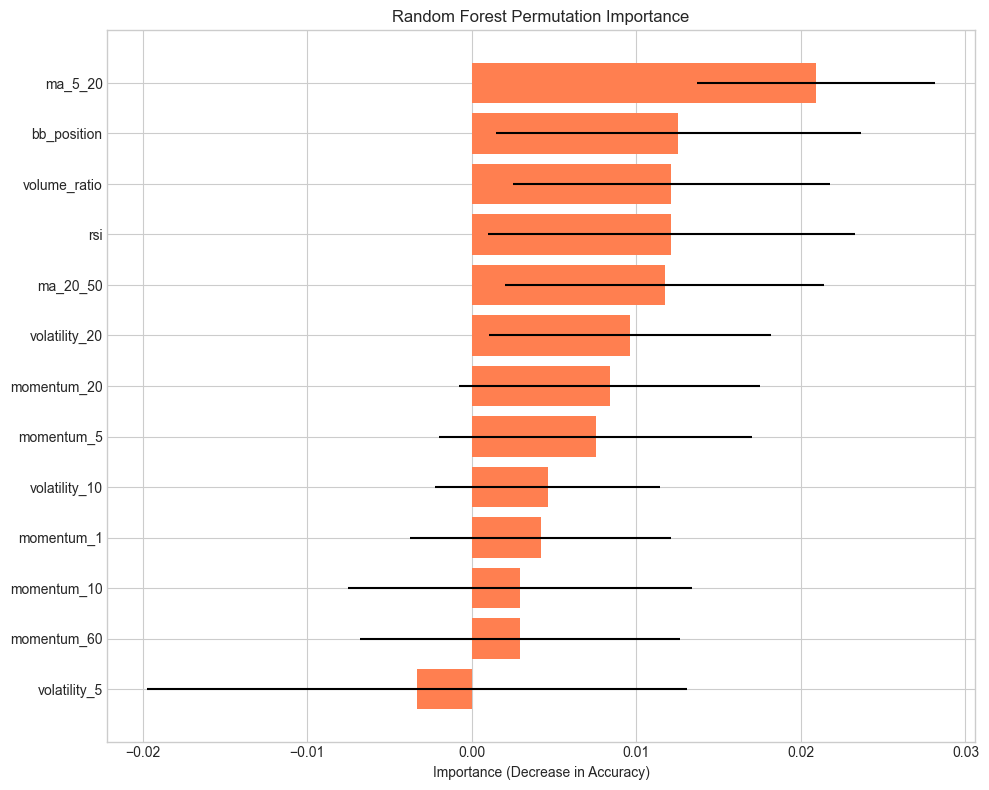

In [9]:
# Permutation Importance (more reliable)
from sklearn.inspection import permutation_importance

print("\n⏳ Computing permutation importance...")
perm_imp = permutation_importance(rf_best, X_test, y_test, n_repeats=10, random_state=42)

perm_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': perm_imp.importances_mean,
    'Std': perm_imp.importances_std
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(perm_importance['Feature'], perm_importance['Importance'], 
         xerr=perm_importance['Std'], color='coral')
plt.xlabel('Importance (Decrease in Accuracy)')
plt.title('Random Forest Permutation Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

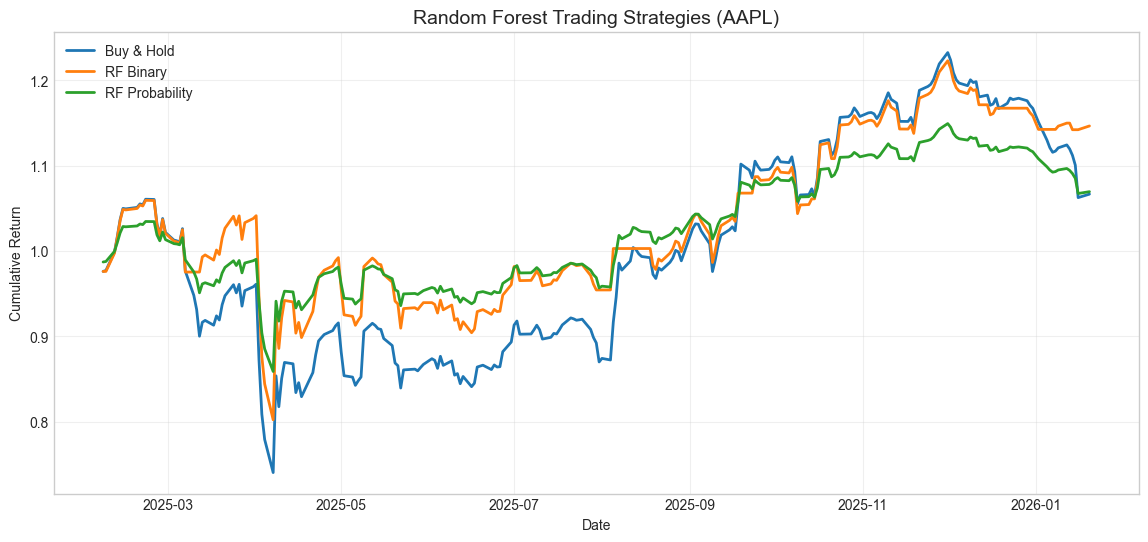

In [10]:
# Trading Strategy Backtest
y_pred = rf_best.predict(X_test)
y_proba = rf_best.predict_proba(X_test)[:, 1]

backtest = pd.DataFrame(index=y_test.index)
backtest['actual_return'] = returns_test.values

# Strategy 1: Binary signal
backtest['signal'] = y_pred
backtest['strategy_return'] = backtest['signal'] * backtest['actual_return']
backtest['strategy_cum'] = (1 + backtest['strategy_return']).cumprod()

# Strategy 2: Probability-weighted
backtest['prob_signal'] = y_proba
backtest['prob_return'] = backtest['prob_signal'] * backtest['actual_return']
backtest['prob_cum'] = (1 + backtest['prob_return']).cumprod()

backtest['buy_hold_cum'] = (1 + backtest['actual_return']).cumprod()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(backtest.index, backtest['buy_hold_cum'], label='Buy & Hold', linewidth=2)
plt.plot(backtest.index, backtest['strategy_cum'], label='RF Binary', linewidth=2)
plt.plot(backtest.index, backtest['prob_cum'], label='RF Probability', linewidth=2)
plt.title(f'Random Forest Trading Strategies ({ticker})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
# Performance Metrics
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*60)
print("STRATEGY PERFORMANCE")
print("="*60)

strategies = [
    ('Buy & Hold', 'actual_return', 'buy_hold_cum'),
    ('RF Binary', 'strategy_return', 'strategy_cum'),
    ('RF Probability', 'prob_return', 'prob_cum')
]

print(f"\n{'Strategy':<20} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10}")
print("-" * 55)

for name, ret_col, cum_col in strategies:
    total, sharpe, mdd = calc_metrics(backtest[ret_col], backtest[cum_col])
    print(f"{name:<20} {total:>12.2%} {sharpe:>10.2f} {mdd:>10.2%}")


STRATEGY PERFORMANCE

Strategy                Total Ret     Sharpe     Max DD
-------------------------------------------------------
Buy & Hold                  6.67%       0.21    -30.22%
RF Binary                  14.66%       0.46    -24.30%
RF Probability              6.96%       0.20    -17.00%


In [12]:
# Next day prediction with confidence interval from trees
latest = X.iloc[-1:]

# Get predictions from all trees
tree_predictions = np.array([tree.predict_proba(latest)[0, 1] for tree in rf_best.estimators_])

print("\n" + "="*60)
print(f"📊 NEXT DAY PREDICTION FOR {ticker}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")

pred = rf_best.predict(latest)[0]
proba = rf_best.predict_proba(latest)[0, 1]

print(f"\nPrediction: {'📈 UP' if pred == 1 else '📉 DOWN'}")
print(f"Mean Probability: {proba:.2%}")
print(f"Std across trees: {tree_predictions.std():.2%}")
print(f"95% CI: [{np.percentile(tree_predictions, 2.5):.2%}, {np.percentile(tree_predictions, 97.5):.2%}]")


📊 NEXT DAY PREDICTION FOR AAPL

Date: 2026-01-20

Prediction: 📈 UP
Mean Probability: 52.60%
Std across trees: 18.90%
95% CI: [10.20%, 96.10%]


---

## 🏢 Real-World Applications

| Company | Random Forest Use Case |
|---------|----------------------|
| Two Sigma | Factor selection |
| AQR | Alpha signal generation |
| BlackRock | Risk factor modeling |
| Citadel | Feature importance analysis |

### Key Interview Points
1. **RF vs Bagging?** - RF adds feature subsampling to decorrelate trees
2. **OOB error?** - Free validation from bootstrap samples
3. **Hyperparameters?** - n_estimators (more=better), max_depth, max_features
4. **Feature importance?** - Mean decrease impurity or permutation importance

---
## 📅 Tomorrow: XGBoost